In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

In [ ]:
CSV_PATHS = [
    "resources/dataset_project_eHealth20252026.csv",
    "resources/questionnaire_codebook_eHealth20252026.csv",
]

In [ ]:
# CSV loader
def load_csv_robust(path: str) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    trials = [
        dict(encoding=None, sep=None, engine="python"),          # auto-detect sep
        dict(encoding="utf-8", sep=None, engine="python"),
        dict(encoding="latin-1", sep=None, engine="python"),
        dict(encoding=None, sep=",", engine="python"),
        dict(encoding=None, sep=";", engine="python"),
    ]
    last_err = None
    for kw in trials:
        try:
            return pd.read_csv(path, **kw)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not read {path} – last error:\n{last_err}")
 

In [ ]:
# Load both CSVs 
for p in CSV_PATHS:
    df = load_csv_robust(p)
    print(f"\n=== Loaded: {p} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print("First 20 column names:", list(df.columns[:20]))
    print("\nDtypes:")
    print(df.dtypes.head(15))


=== Loaded: resources/dataset_project_eHealth20252026.csv ===
Shape: 221 rows × 96 cols
First 20 column names: ['age', 'gender', 'education', 'marital', 'income', 'audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10', 'dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5']

Dtypes:
age          float64
gender         int64
education    float64
marital      float64
income         int64
audit_1        int64
audit_2        int64
audit_3      float64
audit_4        int64
audit_5      float64
audit_6        int64
audit_7      float64
audit_8      float64
audit_9      float64
audit_10     float64
dtype: object

=== Loaded: resources/questionnaire_codebook_eHealth20252026.csv ===
Shape: 96 rows × 4 cols
First 20 column names: ['\ufeffquestion', 'type', 'name of column', '[codification] options (if applicable)']

Dtypes:
﻿question                                 object
type                                      object
name of column            

We need to do some cleaning in dataset csv 
For the Nan values, replace NaN with the mean values of that question

Each prefix is the abbreviation for a different questionnaire or scale:

audit: Alcohol Use Disorders Identification Test

dast: Drug Abuse Screening Test

pgsi: Problem Gambling Severity Index

iat: Internet Addiction Test

pcl5: PTSD Checklist for DSM-5

mspss: Multidimensional Scale of Perceived Social Support

swls: Satisfaction With Life Scale

who5: WHO-5 Well-Being Index

In [6]:
questionnaires = [
    "audit",
    "dast",
    "pgsi",
    "iat",
    "pcl5",
    "mspss",
    "swls",
    "who5"
]

In [ ]:
# Clean data
dataset = load_csv_robust(CSV_PATHS[0])
nan_rows_df1 = dataset.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")

flag_nan_or_empty = dataset.isna() | (dataset == "")
nan_or_empty_rows = dataset.index[flag_nan_or_empty.any(axis=1)].tolist()

print(f"Rows with NaN or empty string values: {nan_or_empty_rows}")

NaN rows in df1: 67
Rows with NaN or empty string values: [2, 6, 8, 13, 17, 18, 28, 29, 31, 35, 37, 39, 49, 53, 57, 59, 61, 62, 64, 66, 68, 69, 74, 79, 82, 83, 88, 91, 92, 95, 96, 100, 105, 107, 109, 110, 111, 114, 115, 116, 117, 120, 122, 129, 132, 133, 140, 141, 142, 149, 151, 156, 157, 162, 165, 170, 173, 181, 183, 195, 199, 201, 204, 206, 214, 215, 219]


In [ ]:
df_filled = dataset.copy()

# Get only the questionnaire columns
questionnaire_cols = dataset.columns[5:]

for q in questionnaires:
    q_cols = [col for col in questionnaire_cols if col.startswith(q + "_")]
    dataset[q_cols] = dataset[q_cols].replace("", np.nan)
    dataset[q_cols] = dataset[q_cols].apply(pd.to_numeric, errors='coerce')
    for idx, row in dataset.iterrows():
        med = row[q_cols].median(skipna=True)
        df_filled.loc[idx, q_cols] = row[q_cols].fillna(med)

# Save the filled dataset locally with a new name
df_filled.to_csv('filled_personal_medians.csv', index=False)

Filling numerical Nan values age and income with median and categorical with mode

In [ ]:
df = pd.read_csv("filled_personal_medians.csv")

cols_to_fill = ["age", "gender", "education", "marital", "income"]

print("NaN BEFORE filling:\n", df[cols_to_fill].isna().sum(), "\n")

for col in cols_to_fill:
    if col not in df.columns:
        print(f"Column '{col}' not found")
        continue

    # If it’s a numeric column,  fill it with the median
    if pd.api.types.is_numeric_dtype(df[col]):
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)
        print(f"{col}: filled NaN with median = {med}")

    else:
        # If it’s a categorical column, fill it with the frequent value
        s = df[col].astype("string").str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        mode_vals = s.mode(dropna=True)
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df[col] = s.fillna(mode_val)
            print(f" {col}: filled NaN with mode = '{mode_val}'")
        else:
            df[col] = s.fillna("Unknown")
            print(f"ℹ {col}: all values were NaN, fill with 'Unknown'")

print("\nNaN AFTER filling:\n", df[cols_to_fill].isna().sum())

# Overwrite the original file
df.to_csv("filled_personal_medians.csv", index=False)
print("\n Updated 'filled_personal_medians.csv' saved and all NaN values replaced")


NaN BEFORE filling:
 age          1
gender       0
education    1
marital      1
income       0
dtype: int64 

✅ age: filled NaN with median = 29.0
✅ gender: filled NaN with median = 1.0
✅ education: filled NaN with median = 13.0
✅ marital: filled NaN with median = 1.0
✅ income: filled NaN with median = 25000.0

NaN AFTER filling:
 age          0
gender       0
education    0
marital      0
income       0
dtype: int64

✅ Updated 'filled_personal_medians.csv' saved — all NaN values replaced.


making the question dast_3 reversed in answers - if someone answered Yes we put to No and vice versa

In [11]:
# Reverse the values in the 'dast_3' column: 0 → 1 and 1 → 0
if "dast_3" in df.columns:
    df["dast_3"] = df["dast_3"].replace({0: 1, 1: 0})
    print("Reversed values for 'dast_3'.")
else:
    print("Column 'dast_3' not found.")

Reversed values for 'dast_3'.


Searching for the outliers at first 5 columns

In [ ]:
personal_cols = ["age", "gender", "education", "marital", "income"]

print("\n=== Basic stats for first 5 personal columns ===")
for col in personal_cols:
    if col not in df.columns:
        print(f"⚠️ Column '{col}' not found in dataset — skipping.")
        continue
    
    # If it’s a numeric column, display the minimum and maximum
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min(skipna=True)
        col_max = df[col].max(skipna=True)
        print(f"{col}: min = {col_min}, max = {col_max}")
    else:
        # If it’s a categorical column, display the number of unique values and the top 3 most frequent ones
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)} unique values → {df[col].value_counts().head(3).to_dict()}")


=== Basic stats for first 5 personal columns ===
age: min = 18.0, max = 40.0
gender: min = 0, max = 3
education: min = 5.0, max = 25.0
marital: min = 0.0, max = 5.0
income: min = 10000, max = 96600


Searching for the outliers in the other columns

In [ ]:
# Manually declare the first 5 columns, the ones with personal info
excluded_cols = ["age", "gender", "education", "marital", "income"]

# Select only numeric questionnaire columns (excluding first 5)
questionnaire_cols = [
    c for c in df.columns
    if c not in excluded_cols and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Number of questionnaire columns: {len(questionnaire_cols)}")

# Compute z-scores for those columns
z_scores = np.abs(stats.zscore(df[questionnaire_cols], nan_policy='omit'))

# Create a boolean mask of outliers (|z| > 3)
outlier_mask = (z_scores > 3)

# Count outliers per column
outlier_counts = pd.DataFrame({
    "num_outliers": outlier_mask.sum(axis=0).astype(int),
    "percent_outliers": (outlier_mask.sum(axis=0) / len(df) * 100).round(2)
})

print("\n=== Outlier Summary (|z| > 3) ===")
display(outlier_counts.sort_values("num_outliers", ascending=False).head(20))

# Mark rows that have at least one outlier
df["has_outlier"] = outlier_mask.any(axis=1)

print(f"\nRows with at least one outlier: {df['has_outlier'].sum()} of {len(df)} total")

# outlier_counts.to_csv("outlier_summary_questionnaires.csv")

Number of questionnaire columns: 91

=== Outlier Summary (|z| > 3) ===


,num_outliers,percent_outliers
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0



Rows with at least one outlier: 0 of 221 total


we are reversing the numeric scale of who, swls and mspss for it to be consistant with other questions

In [14]:
def reverse_scale(series):
    """Return a reversed version of a numeric series."""
    return (series.max() - series) + series.min()

for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
    if col in df.columns:
        df[col + "_reversed"] = reverse_scale(df[col])
        print(f"Created reversed version of {col}")

Summing the values of all questions to the total for each problem

In [ ]:
df = pd.read_csv("filled_personal_medians.csv")

# Define a safe selector: only questions like AUDIT_1, AUDIT_2, ...
def compute_total(prefix):
    cols = [c for c in df.columns if c.upper().startswith(prefix + "_")]
    print(f"{prefix}: found {len(cols)} item columns ->", cols[:10], "..." if len(cols) > 10 else "")
    if cols:
        # convert to numeric just in case
        df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)
        print(f"{prefix}_total added.")
    else:
        print(f"No columns found for {prefix} (check column names).")

# Compute totals for all questionnaire
for prefix in ["AUDIT", "DAST", "IAT", "PGSI", "PCL5", "MSPSS", "SWLS", "WHO5"]:
    compute_total(prefix)

# Quick verification
print(df[[c for c in df.columns if c.endswith("_total")]].head())

# Overwrite the original csv
df.to_csv("filled_personal_medians.csv", index=False)

# Re-load to make sure it was saved
check = pd.read_csv("filled_personal_medians.csv")
print("Totals present after reload:", [c for c in check.columns if c.endswith("_total")])

AUDIT: found 10 item columns -> ['audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10'] 
AUDIT_total added.
DAST: found 10 item columns -> ['dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5', 'dast_6', 'dast_7', 'dast_8', 'dast_9', 'dast_10'] 
DAST_total added.
IAT: found 20 item columns -> ['iat_1', 'iat_2', 'iat_3', 'iat_4', 'iat_5', 'iat_6', 'iat_7', 'iat_8', 'iat_9', 'iat_10'] ...
IAT_total added.
PGSI: found 9 item columns -> ['pgsi_1', 'pgsi_2', 'pgsi_3', 'pgsi_4', 'pgsi_5', 'pgsi_6', 'pgsi_7', 'pgsi_8', 'pgsi_9'] 
PGSI_total added.
PCL5: found 20 item columns -> ['pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7', 'pcl5_8', 'pcl5_9', 'pcl5_10'] ...
PCL5_total added.
MSPSS: found 12 item columns -> ['mspss_1', 'mspss_2', 'mspss_3', 'mspss_4', 'mspss_5', 'mspss_6', 'mspss_7', 'mspss_8', 'mspss_9', 'mspss_10'] ...
MSPSS_total added.
SWLS: found 5 item columns -> ['swls_1', 'swls_2', 'swls_3', 'swls_4', 'swls_5'

C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\3313532568.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)


making a new db just with total values and first 5 columns

In [16]:
# Select the personal columns (first 5)
personal_cols = ["age", "gender", "education", "marital", "income"]

# Select all total score columns (those ending with "_total")
total_cols = [c for c in df.columns if c.endswith("_total")]

# Combine them
columns_to_keep = personal_cols + total_cols

# Create a new DataFrame
df_totals = df[columns_to_keep].copy()

# Quick check
print(df_totals.head())

# Save to a new CSV file
output_name = "totals_with_personal_info.csv"
df_totals.to_csv(output_name, index=False)
print(f"Saved new dataset: {output_name}")

    age  gender  education  marital  income  AUDIT_total  DAST_total  \
0  39.0       0        8.0      1.0   14000         25.0         0.0   
1  18.0       1        5.0      1.0   25000         16.0         0.0   
2  40.0       0       13.0      2.0   56000          0.0         8.0   
3  24.0       1       22.0      0.0   35000          7.0         8.0   
4  19.0       1       22.0      1.0   42000         14.0         4.0   

   IAT_total  PGSI_total  PCL5_total  MSPSS_total  SWLS_total  WHO5_total  
0       39.0        24.0         0.0         51.0         8.0        13.0  
1       33.0         8.0         6.0         43.0        14.0         7.0  
2       60.0         0.0        50.0         18.0         8.0        13.0  
3       56.0         0.0        63.0         26.0        15.0        11.0  
4        0.0         1.0         8.0         61.0        27.0        20.0  
Saved new dataset: totals_with_personal_info.csv


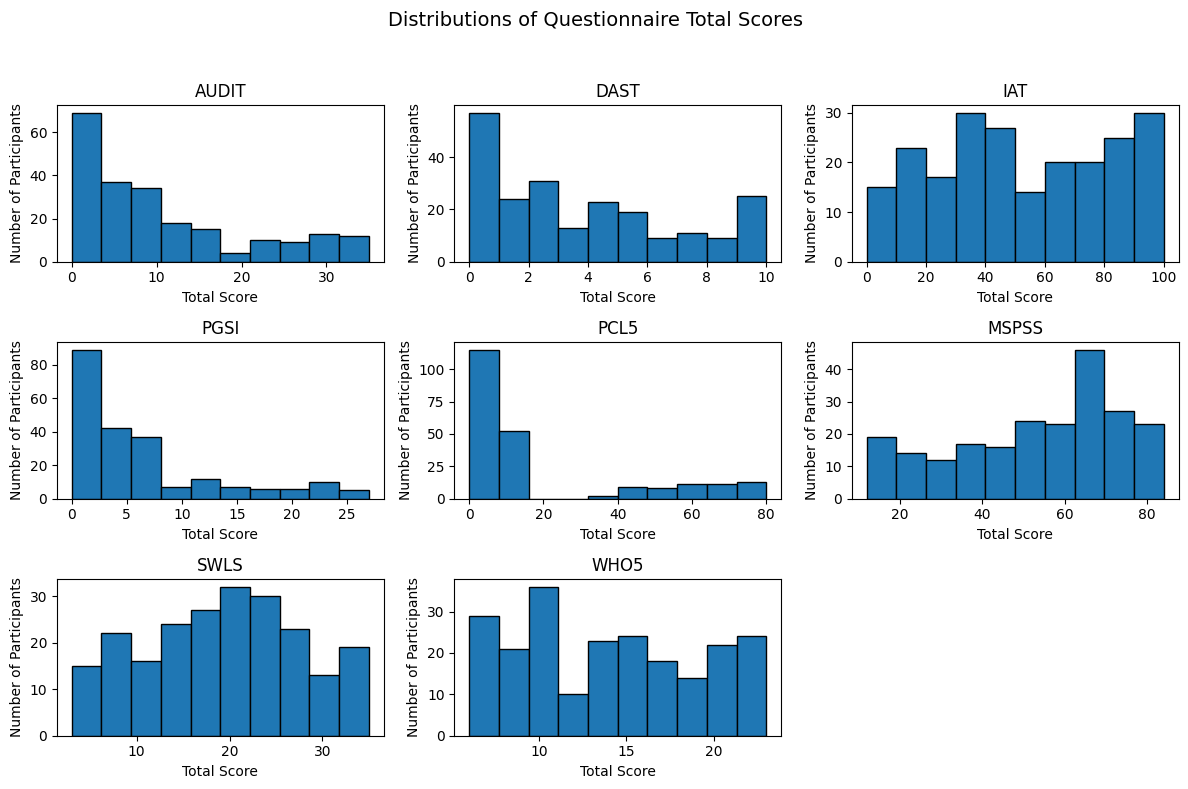

In [17]:
import matplotlib.pyplot as plt

# All columns that end with "_total"
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Create histograms for each total score
axes = df_totals[totals].hist(
    bins=10,
    figsize=(12, 8),
    edgecolor='black',
    grid=False
)

# Add common labels
for ax in axes.flatten():
    ax.set_xlabel("Total Score")          # x-axis
    ax.set_ylabel("Number of Participants")  # y-axis
    ax.set_title(ax.get_title().replace("_total", "").upper())

plt.suptitle("Distributions of Questionnaire Total Scores", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

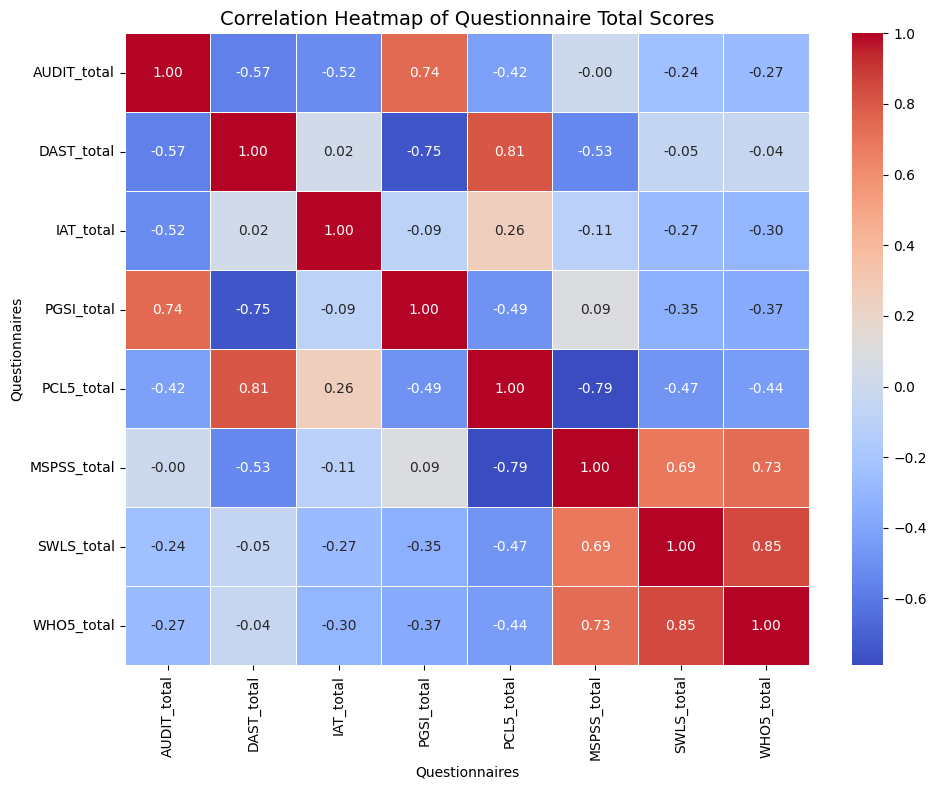

In [ ]:
# Select only the total score columns
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Compute the correlation matrix
corr = df_totals[totals].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,          
    cmap="coolwarm",      
    fmt=".2f",            
    linewidths=0.5
)

plt.title("Correlation Heatmap of Questionnaire Total Scores", fontsize=14)
plt.xlabel("Questionnaires")
plt.ylabel("Questionnaires")
plt.tight_layout()
plt.show()

Co-occurrence of addictions: Alcohol and gambling problems tend to appear together (shared behavioral tendencies).

Different addiction profiles: Drug use (DAST) behaves differently from alcohol/gambling, possibly indicating a separate risk group.

Mental-health context: PTSD symptoms (PCL5) correlate positively with substance-use problems and negatively with social support and well-being.

Protective factors: High social support (MSPSS) and life satisfaction (SWLS/WHO5) move together and counterbalance addiction and trauma scores.

making the heatmap which includes also age, gender, marital status, education, income

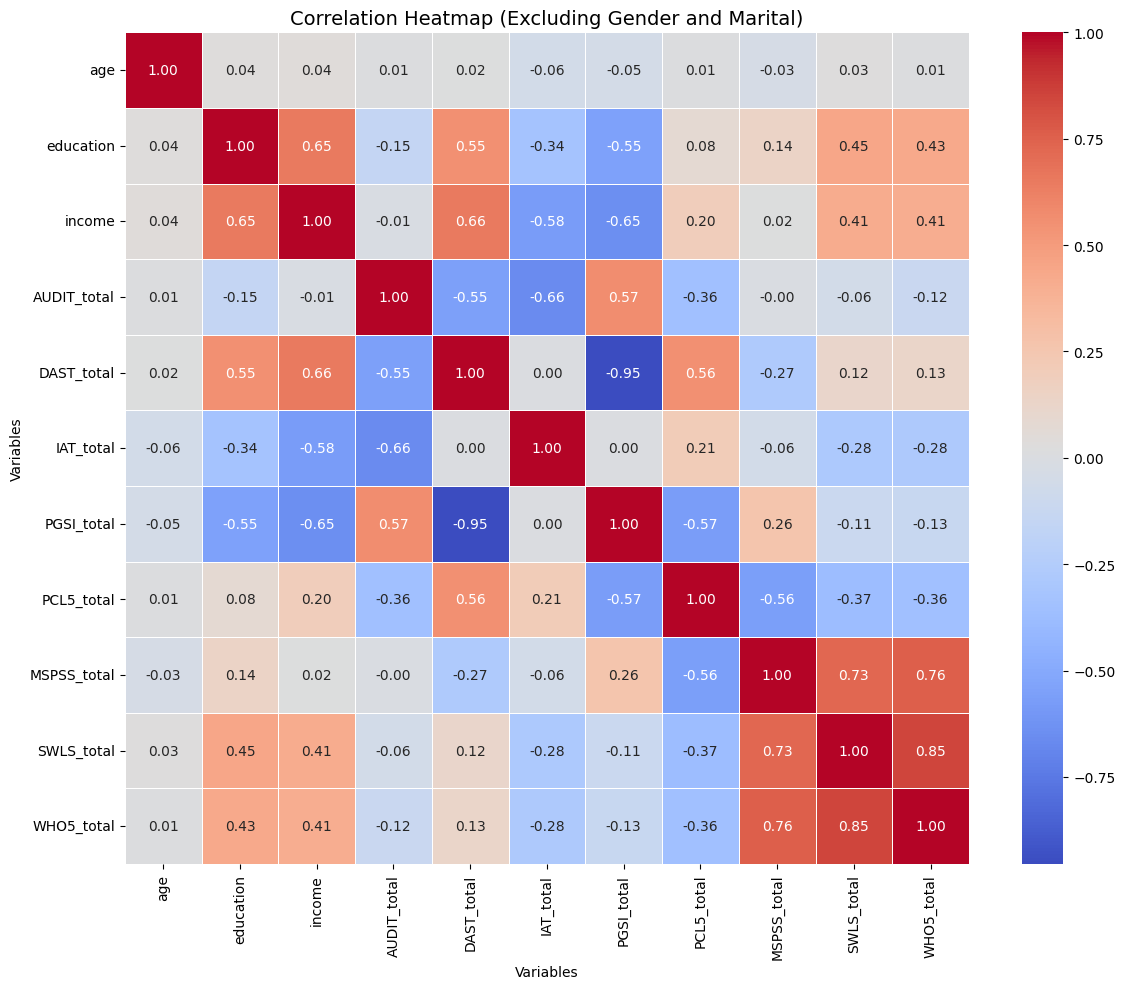

In [19]:
# Make a copy of your df_totals
df_numeric = df_totals.drop(columns=["gender", "marital"], errors="ignore")

# Keep only numeric columns
df_numeric = df_numeric.select_dtypes(include=["number"])

# Compute the correlation matrix (Spearman is best for ordinal/numeric mixes)
corr = df_numeric.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Excluding Gender and Marital)", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()



 The following thresholds are based on the official scoring manuals for each questionnaire. 
 Higher total scores on AUDIT, DAST, IAT, PGSI, and PCL-5 indicate greater severity of addiction 
 or psychological distress, while higher totals on MSPSS, SWLS, and WHO-5 indicate stronger social 
 support and well-being (protective factors). Because these scales are oriented in opposite directions, 
the well-being measures can be reverse-coded when needed so that higher values consistently represent 
 worse outcomes across all questionnaires. This ensures that correlation and clustering analyses are 
conceptually consistent and easier to interpret.

GRAPHS 

C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\2486830773.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


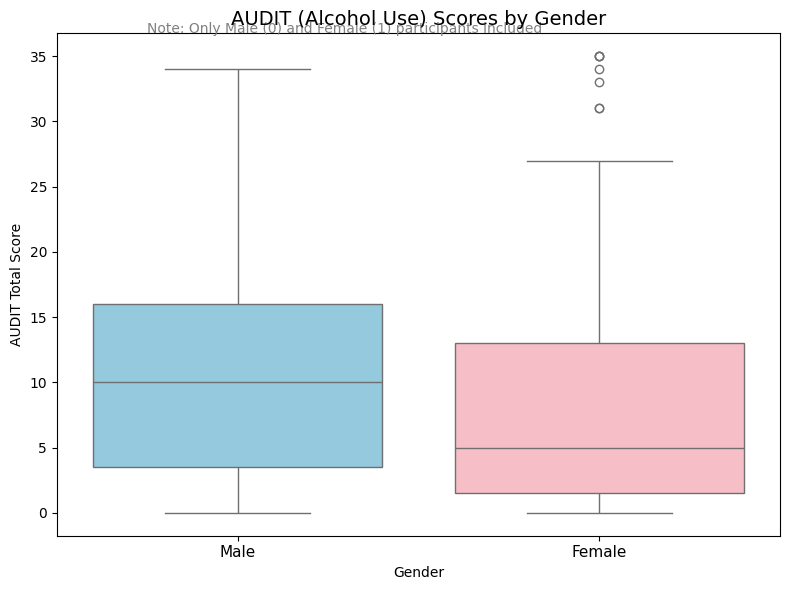

In [ ]:
# Filter only male and female
import seaborn as sns
df_gender = df_totals[df_totals["gender"].isin([0, 1])].copy()

plt.figure(figsize=(8,6))

#  boxplot
sns.boxplot(
    x="gender",
    y="AUDIT_total",
    data=df_gender,
    palette=["skyblue", "lightpink"]
)


plt.title("AUDIT (Alcohol Use) Scores by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("AUDIT Total Score")


plt.xticks([0, 1], ["Male", "Female"], fontsize=11)


plt.text(-0.25, df_gender["AUDIT_total"].max() * 1.05,
         "Note: Only Male (0) and Female (1) participants included",
         fontsize=10, color="gray")

plt.tight_layout()
plt.show()

The median for males is higher → on average, men report more alcohol use than women.

The spread of male scores is also wider → greater variation among men (some drink very little, some very heavily).

The female group has a lower median and smaller variation, but still a few outliers (high-risk drinkers).

C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\2506500132.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\2506500132.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


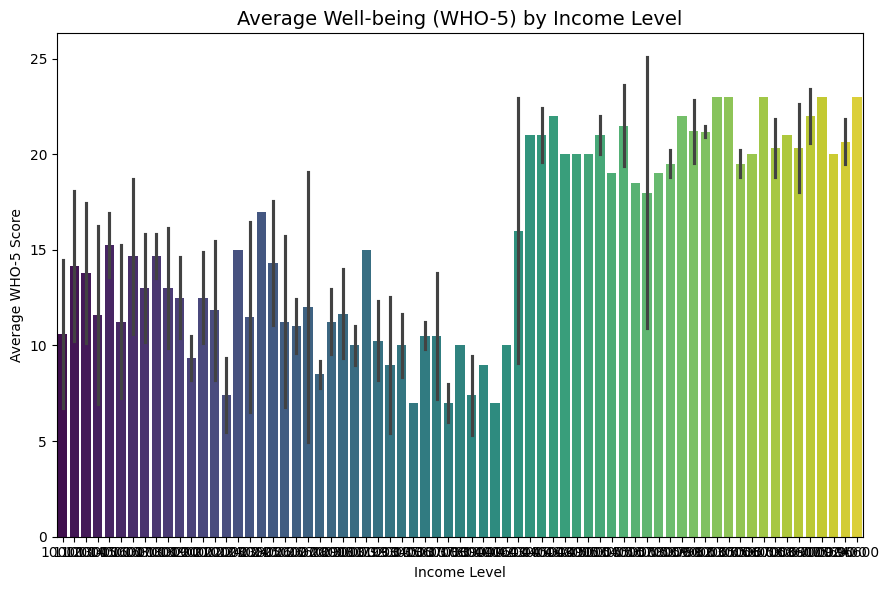

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(
    x="income",
    y="WHO5_total",
    data=df_totals,
    estimator="mean",
    ci="sd",
    palette="viridis"
)

plt.title("Average Well-being (WHO-5) by Income Level", fontsize=14)
plt.xlabel("Income Level")
plt.ylabel("Average WHO-5 Score")

plt.tight_layout()
plt.show()


You can clearly see a positive trend: as income level increases, the average WHO-5 score tends to rise as well.
This means participants with higher income generally report better emotional well-being and life satisfaction.
Lower-income participants show lower and more variable well-being scores, suggesting more instability in reported happiness.
The relationship isn’t perfectly linear (some fluctuations), but the overall trend is upward.

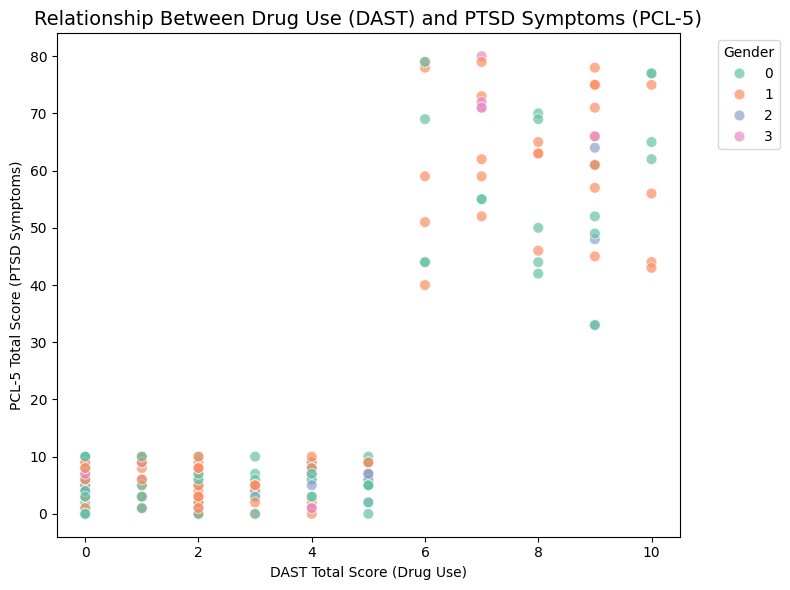

In [ ]:

plt.figure(figsize=(8,6))

sns.scatterplot(
    x="DAST_total",
    y="PCL5_total",
    data=df_totals,
    hue="gender",           
    palette="Set2",
    alpha=0.7,
    s=60
)

plt.title("Relationship Between Drug Use (DAST) and PTSD Symptoms (PCL-5)", fontsize=14)
plt.xlabel("DAST Total Score (Drug Use)")
plt.ylabel("PCL-5 Total Score (PTSD Symptoms)")

plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Each point = one participant.

X-axis: level of drug use.

Y-axis: level of PTSD symptoms.

Color: participant’s gender (optional for visual separation).

Figure X demonstrates a strong positive relationship between drug use and PTSD symptoms. Participants with higher DAST scores consistently show elevated PCL-5 totals, indicating that greater substance use is associated with more severe trauma-related distress. This pattern aligns with evidence of comorbidity between substance use disorders and post-traumatic stress symptoms.

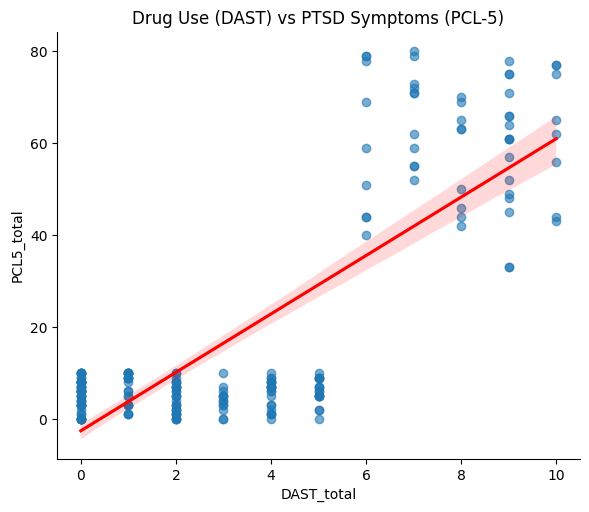

In [42]:
sns.lmplot(x="DAST_total", y="PCL5_total", data=df_totals, aspect=1.2, height=5, scatter_kws={"alpha":0.6}, line_kws={"color":"red"})
plt.title("Drug Use (DAST) vs PTSD Symptoms (PCL-5)")
plt.show()

Creating the severity of the problem based on total values

In [ ]:
# Reverse-code helper (keeps the original column; writes *_rev)
def reverse_scale(s: pd.Series) -> pd.Series:
    # Handles NaNs; preserves original min/max range
    return (s.max(skipna=True) - s) + s.min(skipna=True)

# Create reversed totals for well-being scales (higher = worse on *_rev)
for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
    if col in df.columns:
        df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))

# Severity/risk categorization functions (standard cutoffs)

def cat_audit(x):
    if pd.isna(x): return np.nan
    if x <= 7:   return "low"
    if x <= 15:  return "medium"
    if x <= 19:  return "high"
    return "possible_dependence"

def cat_dast(x):
    if pd.isna(x): return np.nan
    if x == 0:    return "no_problem"
    if x <= 2:    return "low"
    if x <= 5:    return "moderate"
    if x <= 8:    return "substantial"
    return "severe"

def cat_iat(x):
    if pd.isna(x): return np.nan
    if x <= 39:    return "normal"
    if x <= 69:    return "problematic"
    return "severe"

def cat_pgsi(x):
    if pd.isna(x): return np.nan
    if x == 0:     return "non_problem"
    if x <= 2:     return "low_risk"
    if x <= 7:     return "moderate"
    return "problem_gambler"

def cat_pcl5(x):
    if pd.isna(x): return np.nan
    if x <= 19:    return "very_low"
    if x <= 33:    return "possible_ptsd"
    if x <= 49:    return "probable_ptsd"
    return "severe_ptsd"

# For well-being/support, labels on the REVERSED versions (higher = worse)
def cat_mspss(x):
    if pd.isna(x): return np.nan
    if x <= 35:    return "high_support"        # previously low
    if x <= 60:    return "moderate_support"
    return "low_support"                        # previously high

def cat_swls(x):
    if pd.isna(x): return np.nan
    if x <= 9:     return "extremely_satisfied"       # previously dissatisfied
    if x <= 14:    return "satisfied"
    if x <= 19:    return "slightly_above_avg"
    if x == 20:    return "neutral"
    if x <= 25:    return "slightly_dissatisfied"
    if x <= 30:    return "dissatisfied"
    return "extremely_dissatisfied"                  # previously extremely satisfied

def cat_who5(x):
    if pd.isna(x): return np.nan
    return "good_wellbeing" if x < 13 else "poor_wellbeing"

# 4) Apply labels (only if the total exists)
label_map = {
    "AUDIT_total": ("AUDIT_label", cat_audit),
    "DAST_total":  ("DAST_label",  cat_dast),
    "IAT_total":   ("IAT_label",   cat_iat),
    "PGSI_total":  ("PGSI_label",  cat_pgsi),
    "PCL5_total":  ("PCL5_label",  cat_pcl5),
    "MSPSS_total": ("MSPSS_label", cat_mspss),
    "SWLS_total":  ("SWLS_label",  cat_swls),
    "WHO5_total":  ("WHO5_label",  cat_who5),
}

for total_col, (label_col, func) in label_map.items():
    if total_col in df.columns:
        df[label_col] = pd.to_numeric(df[total_col], errors="coerce").apply(func)

# Build a compact export with personals, totals, reversed totals, and labels
personal_cols = [c for c in ["age","gender","education","marital","income"] if c in df.columns]
total_cols    = [c for c in df.columns if c.endswith("_total")]
rev_cols      = [c for c in df.columns if c.endswith("_total_rev")]
label_cols    = [c for c in df.columns if c.endswith("_label")]

export_cols   = personal_cols + total_cols + rev_cols + label_cols
df_export = df[export_cols].copy()

df_export.to_csv("totals_labels_reversed.csv", index=False)
print("Saved: totals_labels_reversed.csv")

Saved: totals_labels_reversed.csv


C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))
C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))
C:\Users\Visnja\AppData\Local\Temp\ipykernel_11592\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

NORMALIZED VALUES - to compare the problems

In [ ]:
totals = [c for c in df.columns if c.endswith("_total")]

# Normalize totals
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df[totals]), columns=[f"{c}_z" for c in totals])

# Combine normalized totals with the original personal info
personal_cols = ["age", "gender", "education", "marital", "income"]
personal_cols = [c for c in personal_cols if c in df.columns]  # keep only those that exist
df_normalized = pd.concat([df[personal_cols], X_scaled], axis=1)

# Save to CSV
df_normalized.to_csv("normalized_totals.csv", index=False)
print("Saved normalized totals to 'normalized_totals.csv'")

Saved normalized totals to 'normalized_totals.csv'


DECIDING THE NUMBER OF CLUSTERS BY ELBOW METHOD - elbow is at 4

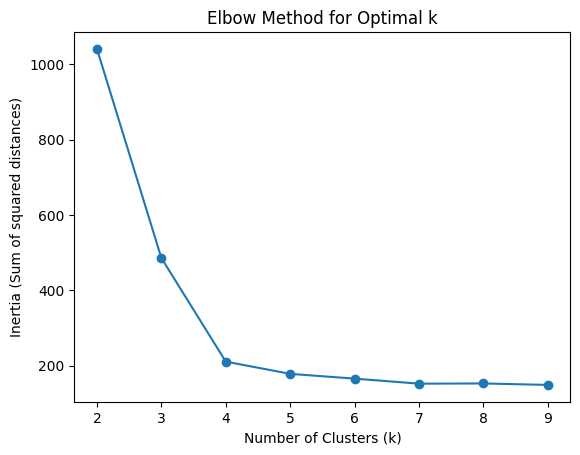

In [ ]:
inertias = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

SILHOUETTE METHOD - higher number is for 4

In [ ]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette score={score:.3f}")

k=2, silhouette score=0.455
k=3, silhouette score=0.574
k=4, silhouette score=0.663
k=5, silhouette score=0.595
k=6, silhouette score=0.581
k=7, silhouette score=0.465
k=8, silhouette score=0.360
k=9, silhouette score=0.221


K MEANS

In [ ]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_totals["cluster"] = kmeans.fit_predict(X_scaled)

In [25]:
print(X_scaled.columns)

Index(['AUDIT_total_z', 'DAST_total_z', 'IAT_total_z', 'PGSI_total_z',
       'PCL5_total_z', 'MSPSS_total_z', 'SWLS_total_z', 'WHO5_total_z'],
      dtype='object')


making clusters

In [26]:
for col in X_scaled.columns:
    df_totals[col] = X_scaled[col]

cluster_summary = df_totals.groupby("cluster")[X_scaled.columns].mean().round(2)
print(cluster_summary)

         AUDIT_total_z  DAST_total_z  IAT_total_z  PGSI_total_z  PCL5_total_z  \
cluster                                                                         
0                -0.76          1.49         0.45         -0.89          1.69   
1                -0.80         -0.58         1.31         -0.06         -0.55   
2                 1.49         -1.07        -0.45          1.45         -0.55   
3                -0.00          0.23        -1.28         -0.57         -0.54   

         MSPSS_total_z  SWLS_total_z  WHO5_total_z  
cluster                                             
0                -1.45         -0.85         -0.85  
1                 0.84          0.42          0.37  
2                -0.25         -0.84         -0.87  
3                 0.84          1.29          1.36  


In [27]:
df_totals.to_csv("clustered_dataset_k4.csv", index=False)
print("Clusters saved to clustered_dataset_k4.csv")

Clusters saved to clustered_dataset_k4.csv


PCA - representing on graph, reducing 8D to 3D

In [ ]:
pca = PCA().fit(X_scaled)
# eigenvalues 
eigs = pca.explained_variance_
k_kaiser = int((eigs > 1.0).sum())
print(f"Kaiser (λ>1): predloženo komponenti = {k_kaiser}")

#how many components explain the 90% variance by keiser method

Kaiser (λ>1): predloženo komponenti = 3


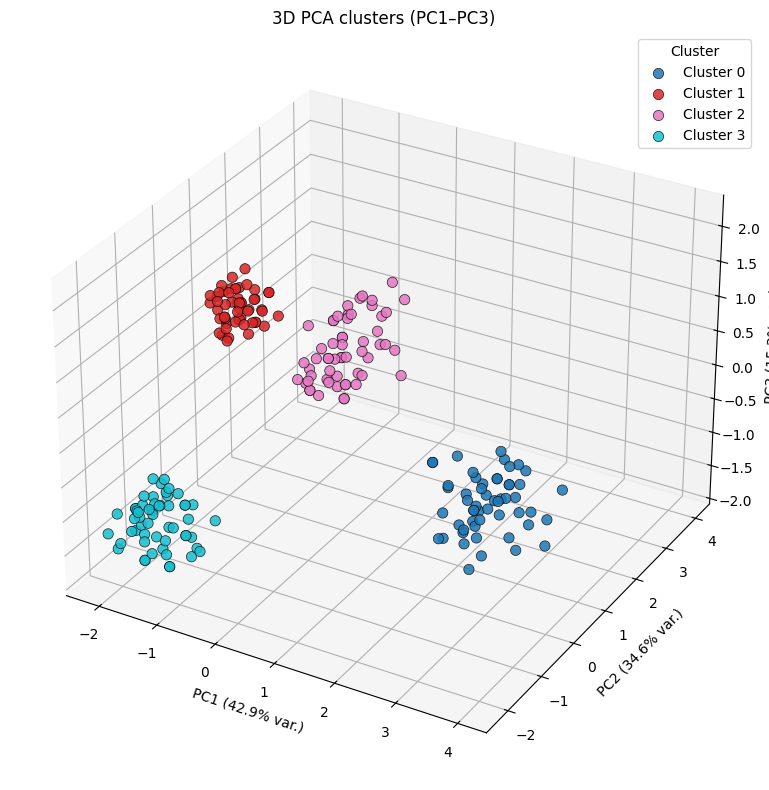

In [ ]:
#presenting 3 components on the graph, first there was 8 and with pca we are reducing to 3

# PCA with 3 components on the same data that used for K-Means
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

# DataFrame with PCA components and clusters
pca_df = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
if "cluster" not in df_totals.columns:
    raise ValueError("Column 'cluster' is missing in df_totals. Run again Kmeans.")
pca_df["cluster"] = df_totals["cluster"].values

# 3D scatter plot colored by clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

clusters = sorted(pca_df["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for c, col in zip(clusters, colors):
    sel = pca_df["cluster"] == c
    ax.scatter(
        pca_df.loc[sel, "PC1"],
        pca_df.loc[sel, "PC2"],
        pca_df.loc[sel, "PC3"],
        s=55, alpha=0.85, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
    )

ax.set_xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}% var.)")
ax.set_ylabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}% var.)")
ax.set_zlabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}% var.)")
ax.set_title("3D PCA clusters (PC1–PC3)")
ax.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

In [31]:
loadings = pd.DataFrame(
    pca3.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=X_scaled.columns
).round(3)
print(loadings)

                 PC1    PC2    PC3
AUDIT_total_z -0.235  0.456 -0.373
DAST_total_z   0.412 -0.299 -0.302
IAT_total_z    0.212 -0.014  0.820
PGSI_total_z  -0.234  0.504  0.104
PCL5_total_z   0.515 -0.058 -0.126
MSPSS_total_z -0.460 -0.217  0.231
SWLS_total_z  -0.316 -0.439 -0.086
WHO5_total_z  -0.314 -0.453 -0.097


The Principal Component Analysis (PCA) revealed three key underlying dimensions explaining most of the variance in participants’ addiction and well-being profiles. PC1 represents a Distress / Addiction versus Well-being dimension, contrasting high levels of drug use and trauma symptoms (DAST, PCL5) with strong social support, life satisfaction, and emotional well-being (MSPSS, SWLS, WHO5). PC2 reflects a Behavioral Risk versus Life Satisfaction dimension, opposing higher alcohol and gambling involvement (AUDIT, PGSI) to greater subjective well-being and satisfaction with life (SWLS, WHO5). Finally, PC3 captures a distinct Digital Dependency dimension, dominated by high Internet Addiction Test (IAT) scores and independent from other forms of addiction or psychological distress. Together, these three components explain most of the variance in the dataset and provide a clear structure for understanding how different forms of addiction and well-being interrelate.

In [32]:
pca_df.to_csv("pca_3d_clusters.csv", index=False)